<a href="https://colab.research.google.com/github/yenlung/Generative-AI-Book/blob/main/%E5%86%92%E9%9A%AA03_%E4%B8%8D%E8%A6%81A%E5%9C%96_%E6%8E%92%E7%A8%8B%E5%99%A8%E5%9C%A8%E5%81%9A%E4%BB%80%E9%BA%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Stable Diffusion 中最神秘的概念大概就是「排程器」(scheduler 或 sampler)。我們來用用不同的排程器, 看要注意什麼地方。

另外, 進行到現在, 你可能發現 Colab 免費版的限制, 也或許想在自己電腦上用 Hugging Face 的 `diffusers` 套件。所以我們也復習設定上需要注意什麼。


### 1. 安裝必要套件

In [2]:
!pip install transformers
!pip install diffusers["torch"]
!pip install accelerate
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 66.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 28.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 851.8/851.8 kB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.3/215.3 kB 29.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 67.2 MB/s eta 0:00:00


### 2. 讀入不同的排程器

`diffusers` 預設是一個叫 PNDM 的排程器，只由浙江大學和 Hugging Face 共同開發的方法。我們現在來用一個叫 "Euler a" (Euler Ancestral) 排程器。

In [3]:
import torch

In [4]:
from diffusers import StableDiffusionPipeline, EulerAncestralDiscreteScheduler

首先再度使用 `chilloutmix` 模型, 當然你可以用任何自己想用的模型。

In [5]:
pipe = StableDiffusionPipeline.from_pretrained("stablediffusionapi/chilloutmix", 
                                               torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


再來指定我們的排程器。

In [52]:
pipe.scheduler = EulerAncestralDiscreteScheduler.from_config(pipe.scheduler.config)

#### 【資源較低的設定說明】

首先是 VRAM 比較少, 或使用 Mac 但 RAM 沒有 64G 的情況, 會建議下以下的指令。Mac VRAM/RAM 是共用的, 所以記憶體很容易被吃掉。

```python
pipe.enable_attention_slicing()
```

再來是讓 GPU 可以休息時就休息, 這建議大家都可以做。

```python
pipe.enable_model_cpu_offload
```

再來 Mac 有個很神奇的地方, 就是要援機才能正常運作! 所以就隨便畫張圖。

```python
prompt = 'a happy rabbit'

_ = pipe(prompt, num_inference_steps=1)
```


### 3. 把四張圖合併的小函式

一樣把我們併圖小函式拿來備用。

In [7]:
from PIL import Image

In [8]:
def combine_imgs(images):
    width, height = images[0].size
    new_img = Image.new('RGB', (width, height))

    w = int(width/2)
    h = int(height/2)

    new_img.paste(images[0].resize((w,h)), (0, 0))
    new_img.paste(images[1].resize((w,h)), (w, 0))
    new_img.paste(images[2].resize((w,h)), (0, h))
    new_img.paste(images[3].resize((w,h)), (w, h))
    return new_img

### 4. 固定個 `random seed`, 試試我們的 scheduler



In [15]:
pipe.safety_checker = lambda images, clip_input: (images, False)

In [21]:
prompt = "masterpiece, best quality, 4k, photo, realistic, 1girl, kpop idol, smiling, (short jacket), sitting in a coffee shop, soft lips, looking at the camera, (brown hair), beautiful detailed eyes, shallow depth of field:1.4, bokeh"
negative_prompt = "ugly, paintings, sketches, worst quality, low quality, normal quality, monochrome, duplicate, morbid, mutilated, mutated hands, poorly drawn hands, blurry, bad anatomy, bad proportions, extra limbs, disfigured"

In [31]:
r = int(np.random.randint(1, 100000000))

In [32]:
r

13717713

寫個指定步數的生圖小函式。

In [55]:
def generate_image(step):
    generator = torch.Generator(device="cpu").manual_seed(r)
    width=512
    height=512

    image = pipe(prompt,
                negative_prompt=negative_prompt,
                width=width,
                height=height,
                generator=generator,
                num_inference_steps=step).images[0]
    return image.resize([int(width/2), int(height/2)])

先來個 20 步試試。

  0%|          | 0/20 [00:00<?, ?it/s]

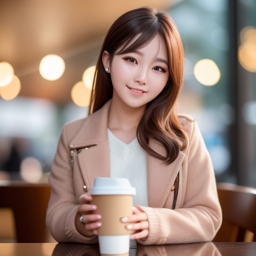

In [56]:
generate_image(20)

來看看 50 步是不是更好了。

  0%|          | 0/50 [00:00<?, ?it/s]

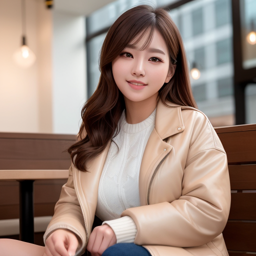

In [57]:
generate_image(50)

等等, 圖好像不一樣了!? 我們看 75 步。

  0%|          | 0/75 [00:00<?, ?it/s]

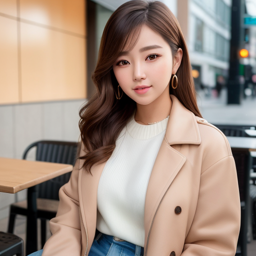

In [59]:
generate_image(75)

### 5. 換個排程器試試

In [60]:
from diffusers import UniPCMultistepScheduler

In [61]:
pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

step 20

  0%|          | 0/20 [00:00<?, ?it/s]

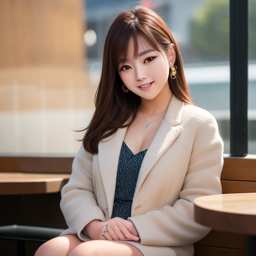

In [62]:
generate_image(20)

step 50

  0%|          | 0/50 [00:00<?, ?it/s]

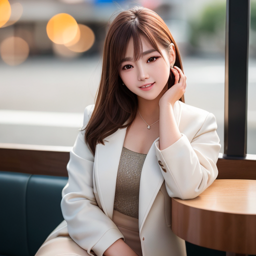

In [63]:
generate_image(50)

step 75

  0%|          | 0/75 [00:00<?, ?it/s]

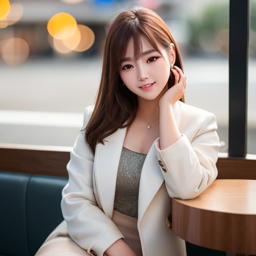

In [64]:
generate_image(75)

step 100

  0%|          | 0/100 [00:00<?, ?it/s]

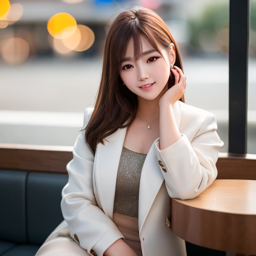

In [65]:
generate_image(100)